## Introduction

Let's begin with a short introduction to what a partial differential equation (PDE) is:
    $$ \phi(u, \partial_x u, \partial_y u, \dots) = 0,$$
This is an unknown function $\phi$ which relates a field $u = u(x,y,\dots)$ and its partial derivatives $\partial_x u$, $\partial_y u$. If that feels abstract and unhelpful, it's because PDEs in the general case are a huge field with applications in nearly every physical phenomenon. We can make further headway by limiting ourselves to PDEs which are like those we see in cardiac excitation dynamics: reaction-diffusion models.

Reaction diffusion PDE models may all be posed in the following generic form,
    $$ \partial_t u = \partial_x^2 u + f(u),$$
where $\partial_t u$ is the derivative of the field $u(t,x)$ with respect to time, and $\partial_x^2 u$ is a  the second-derivative of $u(t,x)$ with respect to space $x$.
For higher-dimensional spaces our space coordinate $x$ becomes a vector, e.g. $x \to \mathbf{x} = [x, y, z]^\top$, and the spatial derivative likewise becomes the sum of second derivatives for each coordinate, e.g. $ \partial_x^2 u \to \partial_x^2 u + \partial_y^2 u + \partial_z^2 u$.
More complex spaces, where the position influences how much diffusion is felt by the system (e.g., fibers in cardiac tissue which impart a preferential direction for conduction) or lower-dimensional domains embedded in higher-dimensional ones with curvature (e.g., the surface of the atria is two-dimensional, curved, and embedded in a three-dimensional space) are beyond the scope of this introduction but very interesting topics.

Let's look at an example.

In [1]:
%config InlineBackend.figure_formats = ['png']

In [2]:
# We're going to import the numerical python and matplotlib modules,
import numpy as np
import matplotlib.pyplot as plt
# make sure our plots show up in the notebook,
%matplotlib inline
# And, eventually, we'll be using this, so might as well import it now
from scipy.integrate import solve_ivp

Recall the FitzHugh-Nagumo model from last time:

In [3]:
def FHN(X,P):
    return np.array([X[0]*(1.0-X[0])*(X[0]-P[1])-X[1], P[3]*(P[0]*X[0]-X[1])])

If we have multiple cells coupled together, and each is modelled by FHN, then we can describe the whole tissue by a PDE, where the coupling takes the form of diffusion.

We are going to approximate the diffusion term in the equation above using a centered finite-difference approximation. This means we will compare the values of $u$ at each point, to the values of $u$ to the left and to the right. The formula below describes a simple approximation of the second derivative of a function $f$, evaluated at position $x$:

$$ f''(x) \approx \frac{f(x+\delta x) + f(x-\delta x) - 2f(x)}{\delta x^2}.$$

We can represent this stencil compactly as `[1,-2,1]`. This stencil is not unique, merely simple. It is possible to derive these stencils yourself using Taylor series expansions! For our purposes, we will just refer to a [pretabulated list of options](https://en.wikipedia.org/wiki/Finite_difference_coefficient). For this example, we will only allow the $u$ variable to diffuse.

In our implementation below, $\delta x=1.0$ is our spatial discretization; this is how far apart our samples of $u$ are in space. You may think about this as analogous to the time-step in our ODE tutorial, but for space! Of course, we still have a time-step for the PDE. 

The most important divergence for PDEs from ODEs are the necessity of boundary conditions. A full mathematical introduction to boundary conditions is beyond our scope -- there is too many interesting things to discuss! -- but we (cardiac dynamics researchers) mostly use _no-flux_ boundary conditions. _No-flux_ means that nothing travels out of or into the numerical domain. We enforce these conditions by folding them into the diffusion stencil. Below, notice that the diffusion stencil described above only applies to `X[1:N,0]`, that is, the values of $u$ which are not touching the boundary. For the boundary elements `X[0,0]` and `X[N,0]` we imagine the domain is mirrored across the boundary edge, and simplify the kernel to only use these interior elements. This is not the only way to implement boundary conditions!

In [4]:
dx = 1.0 # space spacing
N = 256  # how many points in space we should use
x = np.arange(0, N)*dx # space grid

# FHN in space, with diffusive coupling and no-flux boundary conditions
def F(X,P):
    dX = np.zeros_like(X)
    dX[1:-1,0] = X[:-2,0] + X[2:,0] - 2*X[1:-1,0]
    dX[0,0] = 2*(X[1,0] - X[0,0])
    dX[-1,0]= 2*(X[-2,0] - X[-1,0])
    dX *= (1.0/(dx*dx))
    dX[:,0] += X[:,0]*(1.0-X[:,0])*(X[:,0]-P[1])-X[:,1]
    dX[:,1] += P[2]*(P[0]*X[:,0]-X[:,1])
    return dX

Now that we have our model set up, we can try solving it over time. To do so, we need to specify our parameters and initial condition. Here, we will set,
    $$ u(t=0,x) = 0.2 \exp(-10^{-4} x^2), \quad v(t=0,x) = 0,$$
and set our parameters to the same as we used in the ODE tutorial.

In [5]:
P = [0.3, 0.1, 0.01] # model parameters -- same as last time
X = np.zeros((N,2)) # pre-allocating our initial condition
X[:,0] = 0.2 * np.exp(-0.0001*x**2) # we are setting u(t=0,x) = 0.2 * exp(-1e4*x^2)

Same as when we solved the ODE, we need to select a time-step and set those times `t`. For the PDE, we also need to preallocate the solution as an array, here we call it `Xs`, because it is generally pretty expensive to append data to a list repeatedly. We went over the solution steps in detail in the ODE tutorial, so we will ignore those details here. Note that we are using Forward Euler to solve the PDE. Can you explain why we are not using Backward Euler here?

In [6]:
dt = 0.1 # time-step
t = np.arange(0, 300, step=dt) # times for solving the PDE
Xs = np.zeros((len(x),2,len(t))) # preallocated solution array
Xs[:,:,0] = X # make sure we assign the initial condition to the first time-index of the solution array
for n in range(1,len(t)): # and now we solve using Forward Euler
    Xs[:,:,n] = Xs[:,:,n-1] + dt * F(Xs[:,:,n-1],P)

The very nicest thing about PDEs is that they make cool images. Making cool images is what got me initially interested in nonlinear dynamics. Now that we have both time and space, we need to think more carefully about plotting. In the example below, we will present this solution as a pseudo-color mesh plot, or `pcolormesh`. This assigns a color to a variable value everywhere in space and time. We can do that for both the $u(t,x)$ and $v(t,x)$ variables.

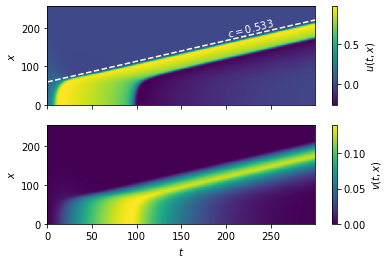

In [7]:
# rasterized=True is important! Don't remove it unless you hate your computer
fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
imu = axs[0].pcolormesh(t, x, Xs[:,0,:], shading="auto", rasterized=True) 
imv = axs[1].pcolormesh(t, x, Xs[:,1,:], shading="auto", rasterized=True) 
plt.colorbar(imu, ax=axs[0], label=r"$u(t,x)$")
plt.colorbar(imv, ax=axs[1], label=r"$v(t,x)$")
axs[-1].set_xlabel(r"$t$")
axs[0].set_ylabel(r"$x$")
axs[1].set_ylabel(r"$x$")
axs[0].plot([0,300],[60,220], "--w")
axs[0].text(200, 175, r"$c={0}$".format(np.round((220-60)/(300-0), decimals=3)), color="w", rotation=14.)
plt.xlim([t[0],t[-1]])
plt.ylim([x[0],x[-1]])
plt.show()

Here we see that our particular initial condition managed to generate an _excitation wave_. These are the fundamental building blocks of patterns in excitable media, with innumerable volumes written about their details in a variety of models. There are still open questions about the conditions under which we can ignite (start) them, or quench (stop) them! Try playing with the amplitude of $u(t=0,x)$ -- for larger amplitudes we get a faster development of the excitation pulse, for very small amplitudes we get no pulse at all, and for amplitudes in the middle we can get whole varieties of interesting behaviors -- like unstable pulses which persist only fleetingly, or one-dimensional spiral waves!

We can also look more closely at the spatial morphology at specific times, or the temporal dynamics at particular positions in space. How you represent the solutions is largely determined by what you find interesting about it. Below is an example of plotting the spatial patterns at the initial (left upper) and final (left lower) times, and plotting the temporal dynamics at the `N/3` (right upper) and `2N/3` spatial positions (right lower). 

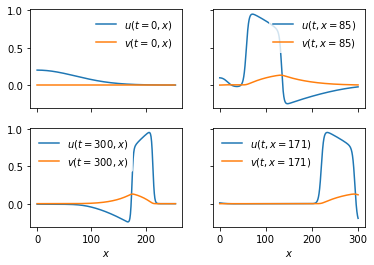

In [8]:
fig, axs = plt.subplots(2,2,sharex="col", sharey=True)
lineObjects = axs[0,0].plot(x,Xs[:,:,0])
axs[0,0].legend(lineObjects, (r"$u(t=0,x)$", r"$v(t=0,x)$"), loc=0, edgecolor="none")
lineObjects = axs[1,0].plot(x,Xs[:,:,-1])
axs[1,0].legend(lineObjects, (r"$u(t=300,x)$", r"$v(t=300,x)$"), loc=0, edgecolor="none")
axs[1,0].set_xlabel(r"$x$")
lineObjects = axs[0,1].plot(t,Xs[85,:,:].transpose())
axs[0,1].legend(lineObjects, (r"$u(t,x=85)$", r"$v(t,x=85)$"), loc=0, edgecolor="none")
lineObjects = axs[1,1].plot(t,Xs[171,:,:].transpose())
axs[1,1].legend(lineObjects, (r"$u(t,x=171)$", r"$v(t,x=171)$"), loc=0, edgecolor="none")
axs[1,1].set_xlabel(r"$x$")
plt.show()

We have elided a lot of inconvenient details in this notebook just to maintain some brevity and focus on relevant methods. But every edge case we descibed for ODEs applies for PDEs -- where stability and accuracy were inconvenient annoyances for ODEs, they can be _catastrophies_ for PDEs. 
In fact, while we have used an explicit method here, explicit methods are in the minority for PDE applications due exactly to issues surrounding stability and robustness. 

Below we give an example of how to adapt the PDE FHN model for `solve_ivp`, which requires our state input `X` to be a 1d array. The same benefits of `solve_ivp` for ODEs apply to PDEs, with adaptive time-stepping, direct error controls, and an availability of methods which may be faster -- occassionally dramatically so! -- for your particular problem. 

PDEs also respond well to a type of solver method we have thus far ignored, the implicit-explicit (IMEX) methods. These are methods which split the PDE model into a linear and nonlinear part, and solve them semi-independently, for speed and accuracy. You can try changing the `method` keyword to `solve_ivp` below to test how reliable and speedy different methods are for this problem.

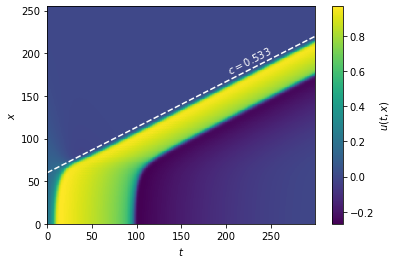

In [9]:
def fun(t,X): # this is the form your ODE must be written in to be used by solve_ivp! 1-dimensional input array!
    dX = np.zeros(2*N)
    dX[0] = 2*(X[1] - X[0])
    dX[1:N-1] = X[:N-2] + X[2:N] - 2*X[1:N-1]
    dX[N-1]= 2*(X[N-2] - X[N-1])
    dX *= (1.0/(dx*dx))
    dX[:N] = dX[:N] + X[:N]*(1.0-X[:N])*(X[:N]-P[1]) - X[N:]
    dX[N:] = P[2]*(P[0]*X[:N] - X[N:])
    return dX

sol = solve_ivp(fun, (0.0, 300.0), X.transpose().flatten(), method='RK45')

im = plt.pcolormesh(sol.t, x, sol.y[:N], shading="auto", rasterized=True) 
plt.colorbar(im, label=r"$u(t,x)$")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.plot([0,300],[60,220], "--w")
plt.text(200, 175, r"$c={0}$".format(np.round((220-60)/(300-0), decimals=3)), color="w", rotation=27.)
plt.xlim([t[0],t[-1]])
plt.ylim([x[0],x[-1]])
plt.show()

## Conclusion

In this tutorial we have looked at the basics of solving reaction diffusion PDEs using finite difference methods and explicit methods, using the FitzHugh-Nagumo model as an example. While we have focused on one dimensional spaces, similar approaches are used in two and three spatial dimensions as well. 